## Credit scoring dataset
### 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
import xgboost as xgb
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = 'sample.xlsx'
xl = pd.ExcelFile(file)
print(xl.sheet_names)
data = xl.parse('data')
data.head(5)

['data', 'description', 'task']


,customer_month_salary,sum_credit_current,term_credit_current,form,sphere,type,EDUCATION,age,marital_status,time_at_work,GENDER,month_passport_issued,month_with_bank,CITY,target,ID
0,52350.25,500000,59,ООО,"Наука, Образование, Здравоохранение",вспомогательный персонал,высшее,44,холост / не замужем,68.0,мужской,124,67.0,Москва,1,1
1,115000.00,400000,60,Иная форма,Другое,специалист,высшее,30,холост / не замужем,96.0,мужской,107,68.0,Москва,1,2
2,87000.00,361000,60,ОАО,"Финансы, управляющие компании, банки, страхование",специалист,Высшее/Второе высшее/Ученая степень,28,женат / замужем,117.0,женский,2,72.0,Москва,1,3
3,145358.17,1499000,60,ЗАО,"Финансы, управляющие компании, банки, страхование",менеджер среднего звена,Высшее/Второе высшее/Ученая степень,30,женат / замужем,35.0,мужской,124,70.0,Москва,1,4
4,50000.00,365000,60,ООО,Другое,специалист,среднее-специальное,31,холост / не замужем,48.0,мужской,131,88.0,Москва,1,5


### 2. Types of data in the dataset

Let's examine what types of data exist in the dataset.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Data columns (total 16 columns):
customer_month_salary    4730 non-null float64
sum_credit_current       4771 non-null int64
term_credit_current      4771 non-null int64
form                     4749 non-null object
sphere                   4752 non-null object
type                     4745 non-null object
EDUCATION                4754 non-null object
age                      4771 non-null int64
marital_status           4771 non-null object
time_at_work             4754 non-null float64
GENDER                   4771 non-null object
month_passport_issued    4771 non-null int64
month_with_bank          3732 non-null float64
CITY                     4767 non-null object
target                   4771 non-null int64
ID                       4771 non-null int64
dtypes: float64(3), int64(6), object(7)
memory usage: 596.5+ KB


We will delete 'ID', as it is not relevant for the analysis.

In [4]:
data.drop(['ID'], axis=1, inplace=True)

Then, we will split features into categorical and numerical.

In [5]:
numerical = []
for col in data.columns:
    if (data[col].dtype == np.int64 or data[col].dtype == np.float64) and not col=='target':
        numerical.append(col)

categorical = []
for col in data.columns:
    if data[col].dtype == np.object:
        categorical.append(col)

print(numerical)
print(categorical)

['customer_month_salary', 'sum_credit_current', 'term_credit_current', 'age', 'time_at_work', 'month_passport_issued', 'month_with_bank']
['form', 'sphere', 'type', 'EDUCATION', 'marital_status', 'GENDER', 'CITY']


### 3. Dealing with missing values
Firstly, we should identify how many missing values the dataset has.

In [6]:
data.isnull().sum()

customer_month_salary      41
sum_credit_current          0
term_credit_current         0
form                       22
sphere                     19
type                       26
EDUCATION                  17
age                         0
marital_status              0
time_at_work               17
GENDER                      0
month_passport_issued       0
month_with_bank          1039
CITY                        4
target                      0
dtype: int64

'Month_with_bank' feature has a quite big number of missing values than other features. Let's look at the distribution of 'month_with_bank'.

Text(0,0.5,'Counts')

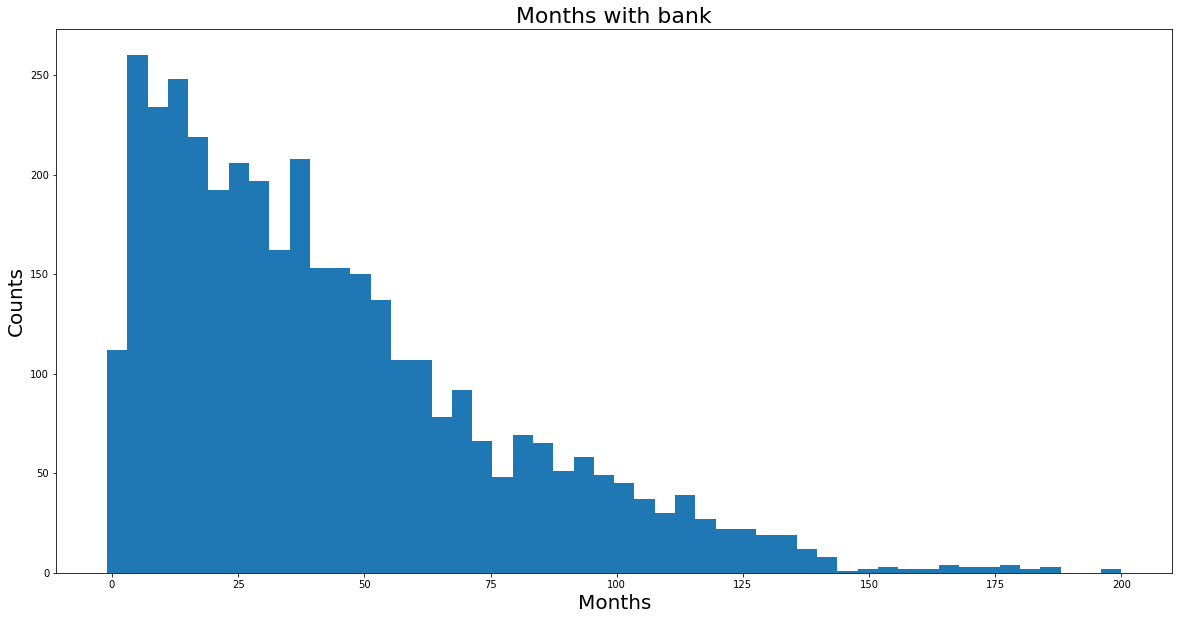

In [7]:
plt.figure(figsize=(20,10))
data.month_with_bank.plot.hist(bins=50)
plt.title('Months with bank', fontsize=22)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Counts', fontsize=20)

Next, we will fill out missing values in the dataset. 

In [8]:
data.fillna(method='ffill', inplace = True)
print(data.isnull().sum())

customer_month_salary    0
sum_credit_current       0
term_credit_current      0
form                     0
sphere                   0
type                     0
EDUCATION                0
age                      0
marital_status           0
time_at_work             0
GENDER                   0
month_passport_issued    0
month_with_bank          0
CITY                     0
target                   0
dtype: int64


Check out the distribution of the 'month_with_bank' feature again (as other features have a few number of missing values, their distribution have not changed - so we have no need to check them).

Text(0,0.5,'Counts')

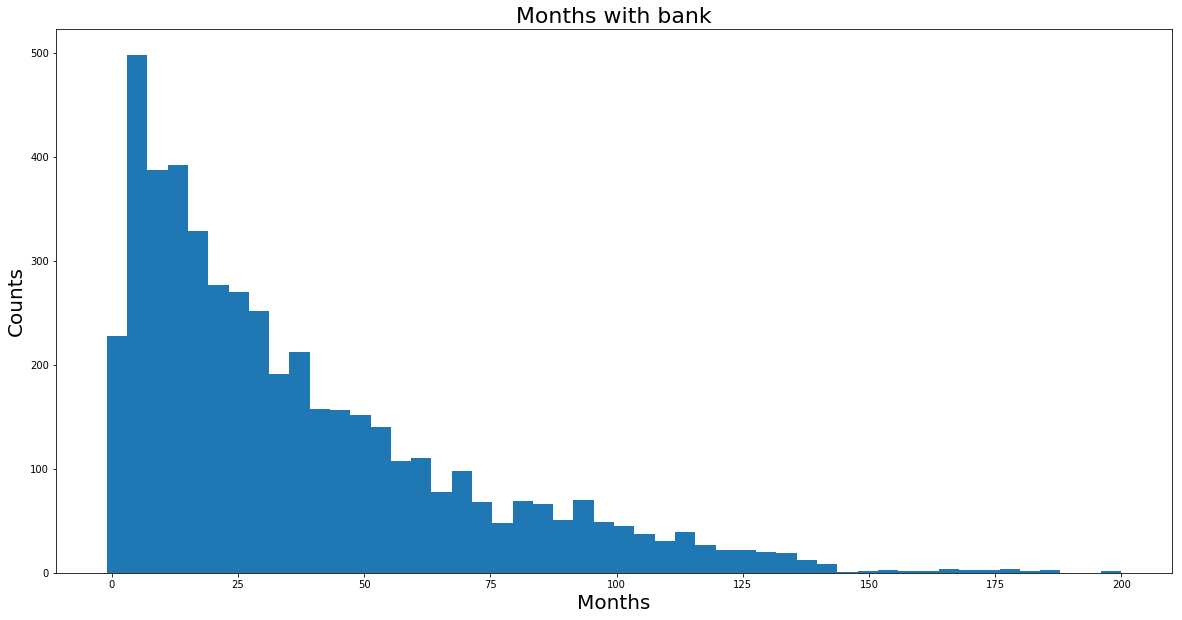

In [9]:
plt.figure(figsize=(20,10))
data.month_with_bank.plot.hist(bins=50)
plt.title('Months with bank', fontsize=22)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Counts', fontsize=20)

As we see, the values have increased, but the the whole distribution is still quite the same. That's exactly what we needed.

### 4. Class balance
Next, we will check out how the dataset is imbalanced. To do that, we have to look at 'target' feature.

In [10]:
data.target.value_counts()

0    3200
1    1571
Name: target, dtype: int64

Classes is not highly imbalanced, so we do not need to implement oversampling/undersampling techniques. Out models will be fine with that.

### 5. Dealing with multicollinearity

As we're going to use linear methods, we have to avoid multicollinearity among the features. To check it, let's make a correlation matrix.

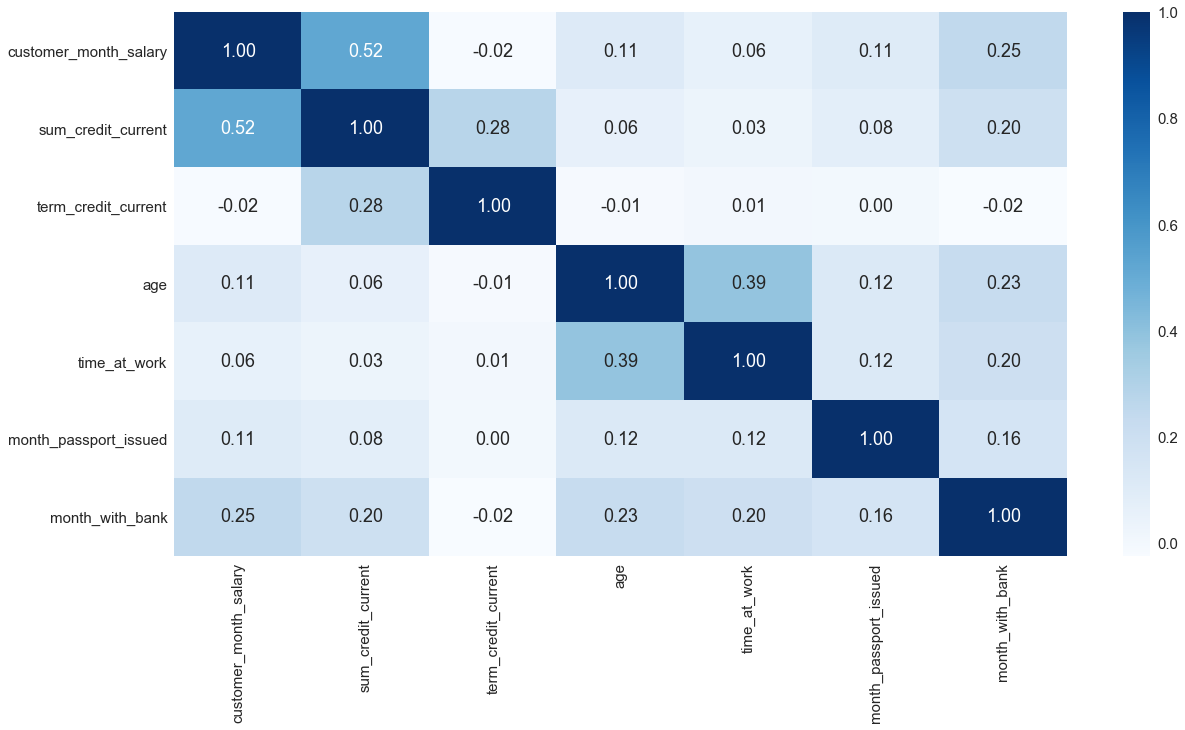

In [11]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.set(font_scale=1.5)
sns.heatmap(data[numerical].corr(), cmap="Blues", annot=True, fmt=".2f")
plt.show()

As we see from the correlation matrix, none of the features have strong correlation (coeff>0.7). There is some medium correlation between 'sum_credit_current' and 'customer_month_salary'. 

As a result, we do not have to exclude features from the dataset.

## Machine learning algorithms

In credit scoring, a model has to be well-understood for a client. From this perspective, we will use **logistic regression** and **decision tree** as the main algorithms.
Let's shortly describe them:
1. Both algotithms tend to overfit, so we have to tune them (l1, l2-regulization for logistic regression and tuning for decision tree).
2. Pre-precessing is crucial for linear algorithms (for example, logistic regression) - checking for multicollinearity, outlier detection, etc.
3. Decision tree algorithm has bigger variance than logistic regression.

In addition, we will implement **Gradient boosting** (xgboost) with tuning. 

### 1. Logistic regression.
### 1.1 Normalization, dummy variables

Fistly, let's normalize numerical features and get dummy varibales for categorical features. As a rule of thumb, it's better for use get_dimmies function rather than OneHotEncoding to avoid multicollinearity between categorical features.

In [12]:
df = pd.DataFrame()
mms = MinMaxScaler()
df[numerical] = pd.DataFrame(mms.fit_transform(data[numerical]))
df = pd.concat([df, pd.get_dummies(data[categorical]), data['target']], axis=1)
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Columns: 117 entries, customer_month_salary to target
dtypes: float64(7), int64(1), uint8(109)
memory usage: 806.1 KB


,customer_month_salary,sum_credit_current,term_credit_current,age,time_at_work,month_passport_issued,month_with_bank,form_Государственное предприятие,form_ЗАО,form_Иная форма,...,CITY_Тольятти,CITY_Томск,CITY_Тула,CITY_Тюмень,CITY_Уфа,CITY_Челябинск,CITY_Череповец,CITY_Чита,CITY_Ярославль,target
0,0.038560,0.058971,0.652778,0.523810,0.142259,0.539130,0.338308,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.084707,0.046424,0.666667,0.190476,0.200837,0.465217,0.343284,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0.064083,0.041531,0.666667,0.142857,0.244770,0.008696,0.363184,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.107068,0.184316,0.666667,0.190476,0.073222,0.539130,0.353234,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.036829,0.042033,0.666667,0.214286,0.100418,0.569565,0.442786,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Then, we will split dataset into training and test subsamples.

In [13]:
X = df.drop('target',axis=1)
Y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=1234)

### 1.2 Gridsearch, AUC-ROC

Next, we will use l1, l2-regularization to avoid overfitting. The best parameters will be chosen by GridSearch.

**Note**: AUC-ROC will be used for scoring. It's important to mention that AUC-PR is have to be used for highly imbalanced classes.

In [14]:
LR = LogisticRegression(random_state=1234)
parameters = {'penalty':['l1', 'l2'], 'C':[10, 9, 8, 7, 6, 5, 4, 3, 2, 1.5, 1.4, 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
clf = GridSearchCV(LR, parameters, scoring='roc_auc', cv=skf)
clf.fit(X_train, y_train)

print('The best parameters for Logistic Regression: ', clf.best_params_)
print('ROC-AUC score on train set: ', round(clf.best_score_, 4))

y_pred = clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, y_pred[:, 1])
print('ROC-AUC score on test set: ', round(roc_score, 4))

The best parameters for Logistic Regression:  {'C': 0.2, 'penalty': 'l2'}
ROC-AUC score on train set:  0.69
ROC-AUC score on test set:  0.6869


L2-regularization model with C=0.2 has the best ROC-AUC score. Then, let's make ROC-curve and define some metrics.

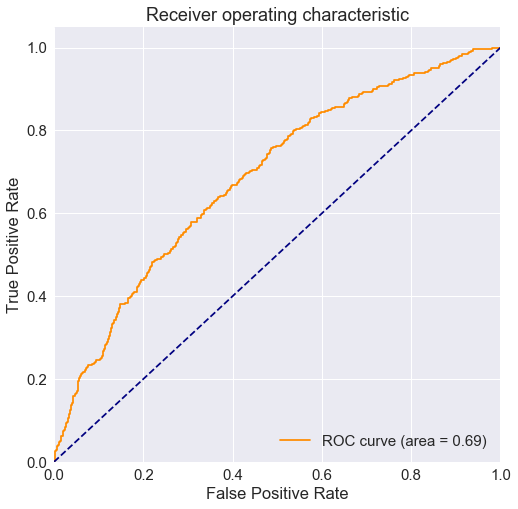

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
def Gini(y_true, y_pred):
    _auc = roc_auc_score(y_true, y_pred)
    return 2*_auc-1

table_scores_total = pd.DataFrame({"Method":['Logistic regression','Decision tree','Xgboost'], 
                 "Precision":[0,0,0], "Recall":[0,0,0], "Gini":[0,0,0]})
table_scores_total['Precision'] = table_scores_total['Precision'].astype(float)
table_scores_total['Recall'] = table_scores_total['Precision'].astype(float)
table_scores_total['Gini'] = table_scores_total['Precision'].astype(float)

y_pred = clf.predict(X_test)
table_scores_total['Precision'][0] = round(precision_score(y_test, y_pred), 2)
table_scores_total['Recall'][0] = round(recall_score(y_test, y_pred), 2)
table_scores_total['Gini'][0] = round(Gini(y_test, y_pred), 2)
table_scores_total

,Method,Precision,Recall,Gini
0,Logistic regression,0.55,0.25,0.14
1,Decision tree,0.00,0.00,0.00
2,Xgboost,0.00,0.00,0.00


At the next step, we will implement l1-regularization with C=0.5. L1-regularization is one of the Embedded Methods of Feature selection that make unimportant features equal to null. Let's also explore importance of the features. 

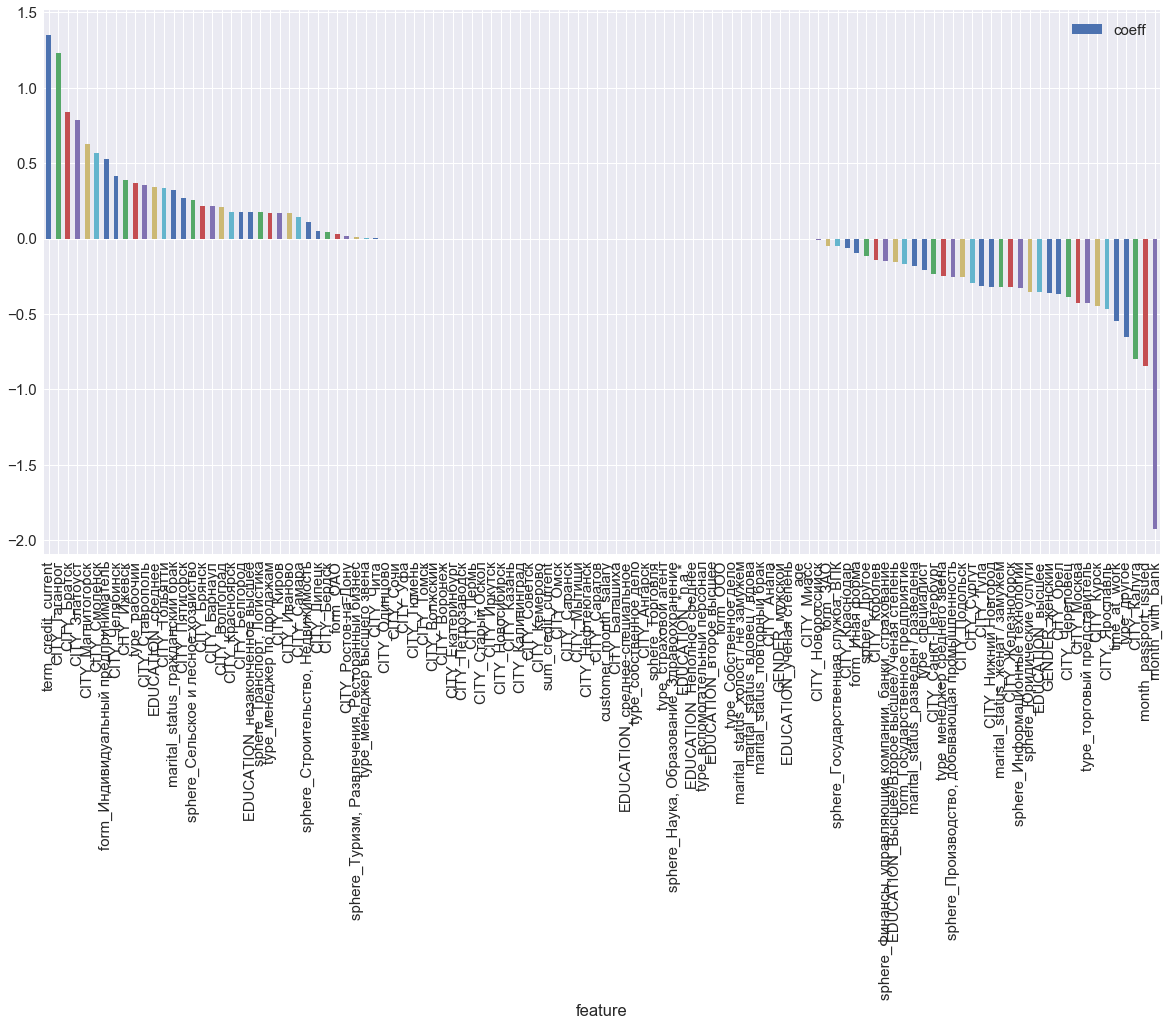

In [29]:
LR_l1 = LogisticRegression(penalty='l1', C=0.5, random_state=1234)
LR_l1.fit(X_train, y_train)
table_log = pd.DataFrame()
table_log['feature'] = X_train.columns
table_log['coeff'] = LR_l1.coef_.reshape(-1,1)
table_log.sort_values('coeff', ascending=False).plot(kind='bar',x='feature',y='coeff', figsize=(20, 10))

### 1.3 Feature selection - RFECV
Next, we will explore another method of feature selection - RFECV (Recursive feature elimination with cross-validation), that select the optimal number of features based on CV score. RFECV is quite good as it improves the score, but it's computationally expensive for large datasets and with algorithms like RandomForest, etc.

In [33]:
LR = LogisticRegression(penalty='l2', C=0.2, random_state=1234)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
selector = RFECV(estimator=LR, step=1, cv=skf, scoring='roc_auc')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

The optimal number of features is 112
The selected features are:
['customer_month_salary', 'sum_credit_current', 'term_credit_current', 'age', 'time_at_work', 'month_passport_issued', 'month_with_bank', 'form_Государственное предприятие', 'form_ЗАО', 'form_Иная форма', 'form_Индивидуальный предприниматель', 'form_ООО', 'sphere_Государственная служба, ВПК', 'sphere_Другое', 'sphere_Информационные технологии', 'sphere_Наука, Образование, Здравоохранение', 'sphere_Производство, добывающая промышленность', 'sphere_Сельское и лесное хозяйство', 'sphere_Строительство, Недвижимость', 'sphere_Торговля', 'sphere_Транспорт, Логистика', 'sphere_Туризм, Развлечения, Ресторанный бизнес', 'sphere_Финансы, управляющие компании, банки, страхование', 'sphere_Юридические услуги', 'type_Собственное дело', 'type_вспомогательный персонал', 'type_другое', 'type_менеджер высшего звена', 'type_менеджер по продажам', 'type_менеджер среднего звена', 'type_рабочий', 'type_собственное дело', 'type_специалист', 't

RFECV selected 112 features out of 117. Selected features are presented above.

Next, let's explore how ROC-AUC score was changing depending on the number of features in the model.

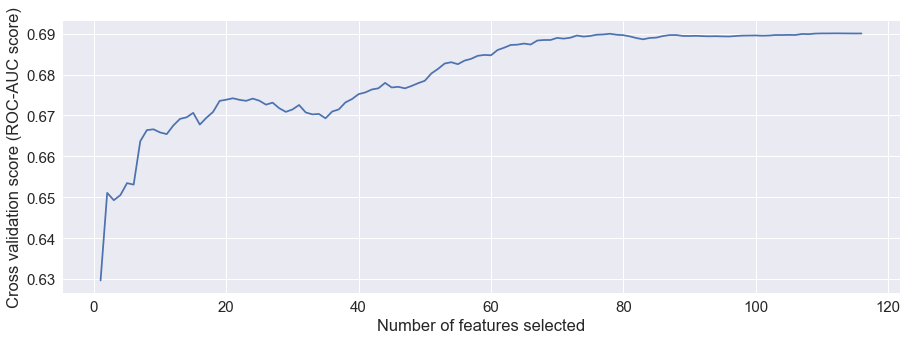

In [34]:
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (ROC-AUC score)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

Then, we will extract feature importance.

In [35]:
selected = selector.estimator_.coef_.reshape(-1, 1)
table_rfecv = pd.DataFrame(selected, columns = ['coeff']) 
table_rfecv['feature'] = features
table_rfecv.sort_values('coeff', ascending=False)

,coeff,feature
2,1.213567,term_credit_current
102,0.721084,CITY_Таганрог
56,0.588006,CITY_Братск
77,0.538257,CITY_Магнитогорск
63,0.537863,CITY_Златоуст
96,0.478817,CITY_Смоленск
10,0.448345,form_Индивидуальный предприниматель
30,0.446864,type_рабочий
108,0.398474,CITY_Челябинск
65,0.383724,CITY_Ижевск


There are many feature selection methods and their implementations in Python. It's up to a data scientist which one to use.

### 1.3 Decision tree

Let's make a training and testing set again for a new method.

In [36]:
df_tree = pd.DataFrame()
df_tree[numerical] = data[numerical]
df_tree = pd.concat([df_tree, pd.get_dummies(data[categorical]), data['target']], axis=1)
df_tree.info()

X = df_tree.drop('target',axis=1)
Y = df_tree.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=1234)

df_tree.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771 entries, 0 to 4770
Columns: 117 entries, customer_month_salary to target
dtypes: float64(3), int64(5), uint8(109)
memory usage: 806.1 KB


,customer_month_salary,sum_credit_current,term_credit_current,age,time_at_work,month_passport_issued,month_with_bank,form_Государственное предприятие,form_ЗАО,form_Иная форма,...,CITY_Тольятти,CITY_Томск,CITY_Тула,CITY_Тюмень,CITY_Уфа,CITY_Челябинск,CITY_Череповец,CITY_Чита,CITY_Ярославль,target
0,52350.25,500000,59,44,68.0,124,67.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,115000.00,400000,60,30,96.0,107,68.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,87000.00,361000,60,28,117.0,2,72.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,145358.17,1499000,60,30,35.0,124,70.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,50000.00,365000,60,31,48.0,131,88.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Next, we will implement Decision tree algorithm with parameter tuning using GridSearch.

In [38]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth':[x for x in range(3, 20)], 'min_samples_leaf': [1, 5, 10, 20, 30, 50, 70, 100, 150, 200, 300, 400, 500]}
dtc = DecisionTreeClassifier(random_state=1234)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
clf = GridSearchCV(dtc, parameters, scoring='roc_auc', cv=skf)
clf.fit(X_train, y_train)

print('The best parameters for Decision Tree: ', clf.best_params_)
print('ROC-AUC score on training set: ', round(clf.best_score_, 4))

y_pred = clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, y_pred[:, 1])
print('ROC-AUC score on test set: ', round(roc_score, 4))

The best parameters for Decision Tree:  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 200}
ROC-AUC score on training set:  0.6609
ROC-AUC score on test set:  0.6516


As we see, ROC-AUC score is lower compared to logistic regression.

Then, we will make ROC-curve.

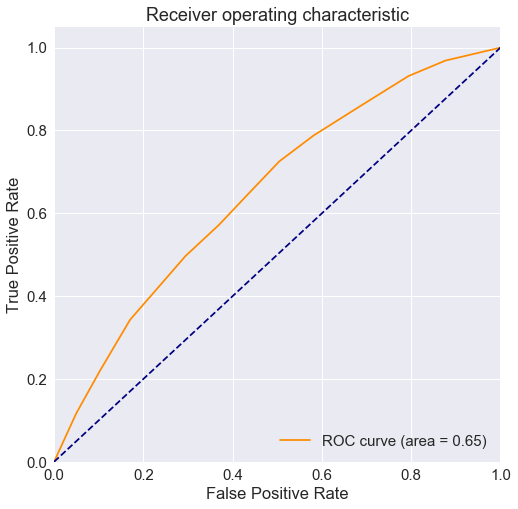

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Define the metrics.

In [40]:
y_pred = clf.predict(X_test)
table_scores_total['Precision'][1] = round(precision_score(y_test, y_pred), 2)
table_scores_total['Recall'][1] = round(recall_score(y_test, y_pred), 2)
table_scores_total['Gini'][1] = round(Gini(y_test, y_pred), 2)
table_scores_total

,Method,Precision,Recall,Gini
0,Logistic regression,0.55,0.25,0.14
1,Decision tree,0.52,0.22,0.12
2,Xgboost,0.00,0.00,0.00


### 1.4 Gradient boosting

Finally, we will examine gradient boosting with early stopping and GridSearch.

In [41]:
df_xgb = pd.DataFrame()
df_xgb[numerical] = data[numerical]
df_xgb = pd.concat([df_xgb, pd.get_dummies(data[categorical]), data['target']], axis=1)

X_gbm = df_xgb.drop('target',axis=1)
Y_gbm = df_xgb.target
X_train, X_test, y_train, y_test = train_test_split(X_gbm, Y_gbm, test_size=0.3, shuffle=True, random_state=1234)

In [42]:
gbm = xgb.XGBClassifier()

xgb_params = {
'learning_rate': [0.01],
'max_depth': [3, 5, 7, 9],
'subsample': [0.5, 1]
}

fit_params = {
'early_stopping_rounds': 5,
'eval_metric': 'auc',
'eval_set': [(X_test, y_test)]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

clf = GridSearchCV(gbm, xgb_params, cv=skf, fit_params=fit_params,)
clf.fit(X_train, y_train)

print('The best parameters for Xgboost trees: ', clf.best_params_)
print('AUC-ROC score on training set: ', round(clf.best_score_, 4))

y_pred = clf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, y_pred[:, 1])
print('AUC-ROC score on test set: ', round(roc_score, 4))

[0]	validation_0-auc:0.593934
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.630593
[2]	validation_0-auc:0.636055
[3]	validation_0-auc:0.641734
[4]	validation_0-auc:0.644015
[5]	validation_0-auc:0.647212
[6]	validation_0-auc:0.645243
[7]	validation_0-auc:0.646114
[8]	validation_0-auc:0.647479
[9]	validation_0-auc:0.648476
[10]	validation_0-auc:0.649612
[11]	validation_0-auc:0.648379
[12]	validation_0-auc:0.64751
[13]	validation_0-auc:0.648925
[14]	validation_0-auc:0.649994
[15]	validation_0-auc:0.648252
[16]	validation_0-auc:0.648425
[17]	validation_0-auc:0.649675
[18]	validation_0-auc:0.651155
[19]	validation_0-auc:0.651663
[20]	validation_0-auc:0.649975
[21]	validation_0-auc:0.649982
[22]	validation_0-auc:0.650309
[23]	validation_0-auc:0.6514
[24]	validation_0-auc:0.651374
Stopping. Best iteration:
[19]	validation_0-auc:0.651663

[0]	validation_0-auc:0.581494
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.6

Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.619718
[2]	validation_0-auc:0.621366
[3]	validation_0-auc:0.631478
[4]	validation_0-auc:0.631798
[5]	validation_0-auc:0.634526
[6]	validation_0-auc:0.638666
[7]	validation_0-auc:0.641063
[8]	validation_0-auc:0.645651
[9]	validation_0-auc:0.646865
[10]	validation_0-auc:0.649208
[11]	validation_0-auc:0.651823
[12]	validation_0-auc:0.650599
[13]	validation_0-auc:0.649677
[14]	validation_0-auc:0.647843
[15]	validation_0-auc:0.647682
[16]	validation_0-auc:0.64946
Stopping. Best iteration:
[11]	validation_0-auc:0.651823

[0]	validation_0-auc:0.586704
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.606587
[2]	validation_0-auc:0.631018
[3]	validation_0-auc:0.63052
[4]	validation_0-auc:0.62612
[5]	validation_0-auc:0.629884
[6]	validation_0-auc:0.633076
[7]	validation_0-auc:0.638125
[8]	validation_0-auc:0.638969
[9]	validation_0-auc:0.63889
[10]	validation_0-auc:0.640681
[1

[7]	validation_0-auc:0.623928
[8]	validation_0-auc:0.627407
[9]	validation_0-auc:0.627262
[10]	validation_0-auc:0.627975
[11]	validation_0-auc:0.629855
[12]	validation_0-auc:0.62915
[13]	validation_0-auc:0.628335
[14]	validation_0-auc:0.630882
[15]	validation_0-auc:0.631236
[16]	validation_0-auc:0.632519
[17]	validation_0-auc:0.630843
[18]	validation_0-auc:0.632518
[19]	validation_0-auc:0.629931
[20]	validation_0-auc:0.630809
[21]	validation_0-auc:0.630802
Stopping. Best iteration:
[16]	validation_0-auc:0.632519

[0]	validation_0-auc:0.624465
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.624456
[2]	validation_0-auc:0.625494
[3]	validation_0-auc:0.625845
[4]	validation_0-auc:0.626041
[5]	validation_0-auc:0.626517
[6]	validation_0-auc:0.626352
[7]	validation_0-auc:0.626544
[8]	validation_0-auc:0.627296
[9]	validation_0-auc:0.627989
[10]	validation_0-auc:0.627394
[11]	validation_0-auc:0.628612
[12]	validation_0-auc:0.628828
[13]	validation_0-auc:0.6

[1]	validation_0-auc:0.611184
[2]	validation_0-auc:0.609981
[3]	validation_0-auc:0.609223
[4]	validation_0-auc:0.608891
[5]	validation_0-auc:0.618372
[6]	validation_0-auc:0.617877
[7]	validation_0-auc:0.617755
[8]	validation_0-auc:0.619047
[9]	validation_0-auc:0.619084
[10]	validation_0-auc:0.617733
[11]	validation_0-auc:0.618815
[12]	validation_0-auc:0.618553
[13]	validation_0-auc:0.617966
[14]	validation_0-auc:0.61912
[15]	validation_0-auc:0.619919
[16]	validation_0-auc:0.620865
[17]	validation_0-auc:0.621207
[18]	validation_0-auc:0.620928
[19]	validation_0-auc:0.620829
[20]	validation_0-auc:0.620569
[21]	validation_0-auc:0.620027
[22]	validation_0-auc:0.620355
Stopping. Best iteration:
[17]	validation_0-auc:0.621207

[0]	validation_0-auc:0.622826
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.624067
[2]	validation_0-auc:0.621732
[3]	validation_0-auc:0.620707
[4]	validation_0-auc:0.623367
[5]	validation_0-auc:0.622669
[6]	validation_0-auc:0.6240

[7]	validation_0-auc:0.637498
[8]	validation_0-auc:0.642283
[9]	validation_0-auc:0.646931
[10]	validation_0-auc:0.647668
[11]	validation_0-auc:0.648131
[12]	validation_0-auc:0.64579
[13]	validation_0-auc:0.645384
[14]	validation_0-auc:0.651345
[15]	validation_0-auc:0.654184
[16]	validation_0-auc:0.656632
[17]	validation_0-auc:0.659793
[18]	validation_0-auc:0.667441
[19]	validation_0-auc:0.66795
[20]	validation_0-auc:0.669188
[21]	validation_0-auc:0.66767
[22]	validation_0-auc:0.667903
[23]	validation_0-auc:0.667443
[24]	validation_0-auc:0.669283
[25]	validation_0-auc:0.668267
[26]	validation_0-auc:0.668478
[27]	validation_0-auc:0.667583
[28]	validation_0-auc:0.668293
[29]	validation_0-auc:0.66863
Stopping. Best iteration:
[24]	validation_0-auc:0.669283

[0]	validation_0-auc:0.633122
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.630491
[2]	validation_0-auc:0.633056
[3]	validation_0-auc:0.633458
[4]	validation_0-auc:0.630835
[5]	validation_0-auc:0.

The ROC-AUC score is similar to decision tree algorithm with tuning, but it's still lower compared to logistic regression.

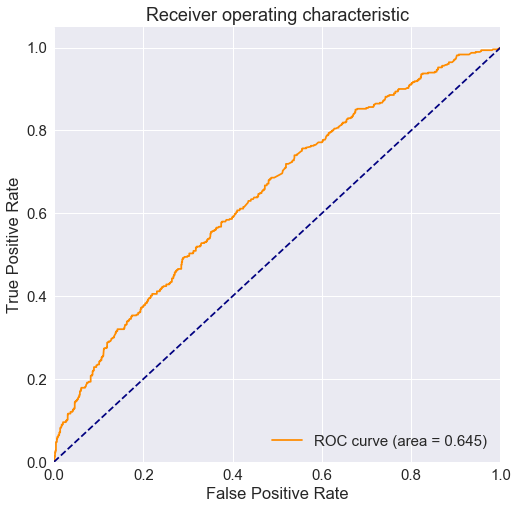

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Посмотрим на важность признаков xgboost модели.

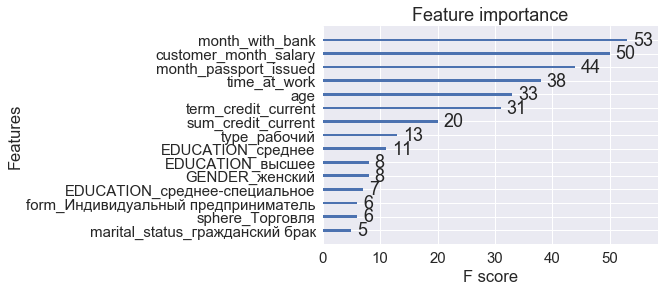

In [44]:
plot_importance(clf.best_estimator_, max_num_features=15)
plt.show()

In [45]:
y_pred = clf.predict(X_test)
table_scores_total['Precision'][2] = round(precision_score(y_test, y_pred), 2)
table_scores_total['Recall'][2] = round(recall_score(y_test, y_pred), 2)
table_scores_total['Gini'][2] = round(Gini(y_test, y_pred), 2)
table_scores_total

,Method,Precision,Recall,Gini
0,Logistic regression,0.55,0.25,0.14
1,Decision tree,0.52,0.22,0.12
2,Xgboost,0.54,0.24,0.14


As a result, the best ML model for this dataset is logistic regression with regularization. Aslso, Xgboost has good results for training subsample, but the score for testing subsample is worse. In addtion, logistic regression is well-understood algorithm for a client, so I recommend to use it for this dataset.

Next, let's make a profile of 'good client' for a bank. We will use coefficients of logistic regression model.
The good client:
- has long credit history
- has an international passport for a long time
- women
- married
- has higher education
- has a job at IT 